# Spectral Clustering
Spectral clustering is a powerful and versatile clustering method that is based on the principles of graph theory and linear algebra. Instead of directly clustering the data in the input space, it constructs a similarity graph where data points are nodes and edges represents similarities between the points.

The algorithm then leverages the spectral properties of the graph (i.e., the eigenvalues and eigenvectors of the graph’s Laplacian matrix) to project the data into a lower-dimensional space. In the transformed space, traditional clustering techniques, such as k-means, can be applied more effectively, even when the data has complex, non-linear boundaries in the original space.

## Similarity Graph
The first step in spectral clustering is to represent the data as a graph, where each node corresponds to a data point, and edges connect nodes based on the distance (or similarity) between the points.

There are three common ways to construct the similarity graph:

1. **Fully connected:** Every node is connected to every other node, and the edges of the graph are weighted by the similarity of their endpoints.
2. **k-nearest neighbors:** Each node is connected only to its k nearest nodes.
3. **$\epsilon$-neighborhood:** Nodes are connected only if their distance is less than $\epsilon$.

In the case of a fully connected graph, the weighted adjacency matrix (or adjacency matrix, for short) $W$ of the graph is defined as follows:

$$W_{ij} = \begin{cases}
    s(x_i, x_j), \quad i \neq j \\
    0, \quad\quad i = j
    \end{cases}
$$

where $s(x_i, x_j)$ is the the similarity between data points $x_i$ and $x_j$. A commonly used similarity function is the Gaussian radial basis function (RBF):

$$s(x_i, x_j) = \exp{(- \frac{|| x_i - x_j ||^2}{2 \sigma^2})}$$

where $\sigma$ is a parameter that controls the width of the neighborhood around each point. For k-nearest neighbors and $\epsilon$-neighborhood graphs, the adjacency matrix is usually binary, i.e., $W_{ij} = 1$ if nodes $i$ and $j$ are connected, and 0 otherwise.

For example, assume that we have the following dataset of 10 two-dimensional points:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X = np.array([[0, 1], [1, 4], [1, 9], [2, 2], [2, 7], 
              [3, 8], [4, 7], [5, 3], [6, 4], [7, 3]])

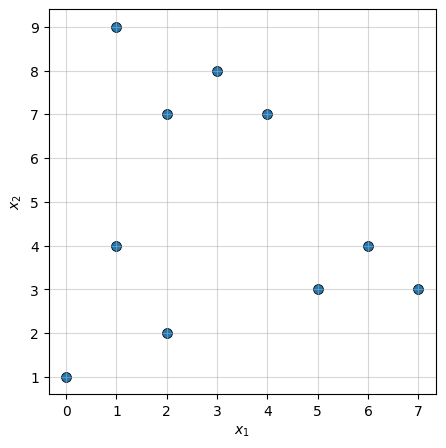

In [3]:
def plot_data(X):   
    plt.figure(figsize=(5, 5))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], edgecolor='k', s=50, legend=False)    
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')    
    plt.grid(alpha=0.5)

plot_data(X)

We now build a fully-connected similarity graph from this dataset, using the RBF similarity function. The adjacency matrix of this graph can be easily computed using the following Python function:

In [4]:
def similarity_graph(X, sigma):
    W = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(len(X)):
            if i != j:
                W[i, j] = np.exp(-np.sum((X[i] - X[j])**2) / (2 * sigma**2))
    return W

In [7]:
W = similarity_graph(X, sigma=3)
print(np.round(W, 3))

[[0.    0.574 0.027 0.757 0.108 0.04  0.056 0.2   0.082 0.053]
 [0.574 0.    0.249 0.757 0.574 0.329 0.368 0.389 0.249 0.128]
 [0.027 0.249 0.    0.062 0.757 0.757 0.486 0.056 0.062 0.018]
 [0.757 0.757 0.062 0.    0.249 0.128 0.2   0.574 0.329 0.236]
 [0.108 0.574 0.757 0.249 0.    0.895 0.801 0.249 0.249 0.103]
 [0.04  0.329 0.757 0.128 0.895 0.    0.895 0.2   0.249 0.103]
 [0.056 0.368 0.486 0.2   0.801 0.895 0.    0.389 0.486 0.249]
 [0.2   0.389 0.056 0.574 0.249 0.2   0.389 0.    0.895 0.801]
 [0.082 0.249 0.062 0.329 0.249 0.249 0.486 0.895 0.    0.895]
 [0.053 0.128 0.018 0.236 0.103 0.103 0.249 0.801 0.895 0.   ]]


Once the data is represented as a similarity graph, the clustering problem turns into a **graph partitioning problem,** where our goal is to find a partition of the graph such that the edges between clusters (groups of nodes) have low weight and the edges within a cluster have high weight.

## The Degree Matrix
The next step in the algorithm is to compute the degree matrix, which is a diagonal matrix whose diagonal elements correspond to the sum of the weights of the edges connected to each node in the graph:

$$D_{ii} = \sum_{j=1}^n w_{ij}$$

In [8]:
def degree_matrix(W):
    D = np.zeros_like(W)
    for i in range(len(W)):
        D[i, i] = np.sum(W[i])
    return D

In [9]:
D = degree_matrix(W)
print(np.round(D, 3))

[[1.896 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    3.618 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    2.475 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    3.293 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    3.986 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    3.596 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    3.928 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    3.751 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    3.497 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    2.585]]


## The Graph Laplacian
We can now derive the graph Laplacian matrix, which is defined as the difference between the degree matrix and the adjacency matrix:

$$L=D-W$$

In [10]:
L = D - W
print(np.round(L, 3))

[[ 1.896 -0.574 -0.027 -0.757 -0.108 -0.04  -0.056 -0.2   -0.082 -0.053]
 [-0.574  3.618 -0.249 -0.757 -0.574 -0.329 -0.368 -0.389 -0.249 -0.128]
 [-0.027 -0.249  2.475 -0.062 -0.757 -0.757 -0.486 -0.056 -0.062 -0.018]
 [-0.757 -0.757 -0.062  3.293 -0.249 -0.128 -0.2   -0.574 -0.329 -0.236]
 [-0.108 -0.574 -0.757 -0.249  3.986 -0.895 -0.801 -0.249 -0.249 -0.103]
 [-0.04  -0.329 -0.757 -0.128 -0.895  3.596 -0.895 -0.2   -0.249 -0.103]
 [-0.056 -0.368 -0.486 -0.2   -0.801 -0.895  3.928 -0.389 -0.486 -0.249]
 [-0.2   -0.389 -0.056 -0.574 -0.249 -0.2   -0.389  3.751 -0.895 -0.801]
 [-0.082 -0.249 -0.062 -0.329 -0.249 -0.249 -0.486 -0.895  3.497 -0.895]
 [-0.053 -0.128 -0.018 -0.236 -0.103 -0.103 -0.249 -0.801 -0.895  2.585]]


The diagonal entries of the Laplacian are the degrees of the nodes, and its off-diagonal entries are the negatives of the edge weights.

The spectral properties of the Laplacian provide information on the graph’s topology, which can be used to partition the graph into its underlying components. More specifically, $L$ has the following useful properties:

1. $L$ is symmetric (as both $W$ and $D$ are symmetric). Therefore, $L$ has $n$ real (not necessarily distinct) eigenvalues.
2. $L$ is a positive semi-definite matrix, which means that all the eigenvalues of $L$ are non-negative.
3. The smallest eigenvalue of $L$ is 0, and its corresponding eigenvector is 1 (the vector of all ones).
4. If the graph has $k$ connected components, then $L$ has $k$ eigenvalues of zeros, and their corresponding eigenvectors are the indicator vectors of these components.
5. For every vector $u$, we have:

$$u^T L u = \frac{1}{2} \sum_{i,j=1}^n w_{ij} (u_i - u_j)^2$$

We can interpret the last property of the Laplacian as follows. A small eigenvalue $\lambda$ of $L$ is associated with a unit eigenvector $u$, in which a pair of coordinates $u_i$ and $u_j$ are close to each other ($(u_i - u_j)^2$ is small) if and only if data points $x_i$ and $x_j$ have a high similarity ($w_{ij}$ is large).

This means that coordinates that are close to each other in eigenvectors of $L$ corresponding to small eigenvalues indicate groups of similar data points and are likely to be part of the same cluster. In other words, the eigenvectors associated with the smallest eigenvalues of $L$ provide insights into the graph's connectivity structure, and may be used to partition the graph into clusters of similar points.

In [11]:
eigen_vals, eigen_vecs = np.linalg.eig(L)

# sort the eigenvectors by their corresponding eigenvalues
sorted_idx = np.argsort(eigen_vals)
eigen_vals = eigen_vals[sorted_idx]
eigen_vecs = eigen_vecs[:, sorted_idx]

print(np.round(eigen_vals, 3))

[-0.     1.547  1.822  3.253  3.609  4.001  4.278  4.576  4.707  4.833]


In [12]:
print(np.round(eigen_vecs, 3))

[[-0.316 -0.665  0.467  0.384  0.291  0.08  -0.009  0.023  0.013  0.015]
 [-0.316 -0.1    0.135 -0.366 -0.216 -0.33  -0.712 -0.043 -0.161 -0.218]
 [-0.316  0.494  0.33   0.526 -0.48   0.169 -0.042 -0.007  0.013 -0.096]
 [-0.316 -0.282  0.064 -0.384 -0.534 -0.075  0.58  -0.197  0.048  0.024]
 [-0.316  0.242  0.138 -0.158  0.179 -0.159 -0.081  0.021  0.297  0.803]
 [-0.316  0.318  0.137 -0.128  0.413 -0.147  0.314  0.03  -0.679 -0.108]
 [-0.316  0.215  0.015 -0.181  0.361  0.019  0.108 -0.022  0.633 -0.526]
 [-0.316 -0.093 -0.292 -0.115 -0.099  0.371 -0.028  0.801 -0.055  0.023]
 [-0.316 -0.034 -0.375 -0.034  0.097  0.612 -0.184 -0.56  -0.135  0.089]
 [-0.316 -0.095 -0.621  0.455 -0.011 -0.54   0.055 -0.045  0.026 -0.007]]


In this case, $L$ has a single eigenvalue of 0, because the graph has only one connected component.

The second eigenvector, which corresponds to the second smallest eigenvalue, is called the **Fiedler vector.** This vector can be used to split the graph into two sets of nodes: $C_1 = \{v_1, v_2, v_4, v_8, v_9, v_{10}\}$, which have a negative value in this vector, and $C_2 = \{v_3, v_5, v_6, v_7\}$, which have a positive value in this vector.

We can further use the third eigenvector, which corresponds to the third smallest eigenvalue, to split $C_1$ into two sub-clusters: $C_{11} = \{v_1, v_2, v_4\}$, where the nodes have a positive value in this vector, and $C_{12} = \{v_8, v_9, v_{10}\}$, where the nodes have a negative value in this vector. Using the second and third eigenvectors of the Laplacian we are able to detect the natural clustering of the data points.

## Spectral Embedding
Instead of manually examining the eigenvectors, we can apply a standard clustering algorithm such as k-means on the components of the eigenvectors in order to extract the clusters from them.

We first build a matrix $U \in R^{n \times k}$ whose columns are the first $k$ eigenvectors of $L$ (corresponding to the $k$ smallest eigenvalues of $L$), where $k$ is typically the number of desired clusters. Then, we use the rows of $U$ as new representations of the data points in a reduced $k$-dimensional space, and apply $k$-means clustering on these rows.

For example, let's build the matrix $U$ from the first three eigenvectors of the Laplacian and the apply $k$-means clustering on the rows of $U$:

In [13]:
k = 3  # number of clusters
U = eigen_vecs[:, :k]
U

array([[-0.31622777, -0.66510614,  0.4674681 ],
       [-0.31622777, -0.09954614,  0.1352768 ],
       [-0.31622777,  0.49408448,  0.33012228],
       [-0.31622777, -0.28153189,  0.06437242],
       [-0.31622777,  0.24178514,  0.13840402],
       [-0.31622777,  0.31760275,  0.1372834 ],
       [-0.31622777,  0.21481473,  0.01524696],
       [-0.31622777, -0.09294785, -0.29215829],
       [-0.31622777, -0.03385325, -0.37465013],
       [-0.31622777, -0.09530183, -0.62136557]])

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k, n_init='auto')
kmeans.fit_predict(U)

array([0, 0, 2, 0, 2, 2, 2, 1, 1, 1])

Indeed, we have discovered the three natural clusters in the dataset: $\{v_1, v_2, v_4\}, \{v_3, v_5, v_6, v_7\}$, and $\{v_8, v_9, v_{10}\}$.

## Spectral Clustering in Scikit-Learn
Scikit-Learn provides an implementation of the spectral clustering algorithm in the class `sklearn.cluster.SpectralClustering`.

In [16]:
from sklearn.datasets import make_moons
from sklearn.cluster import SpectralClustering

In [17]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

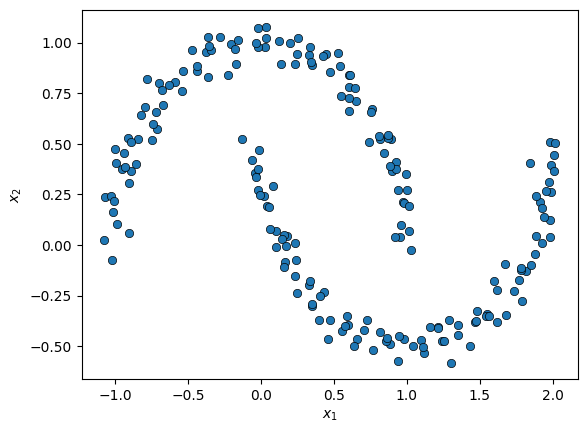

In [18]:
def plot_data(X):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], edgecolor='k', legend=False)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

plot_data(X)

In [19]:
sc = SpectralClustering(n_clusters=2, random_state=0)
labels = sc.fit_predict(X)

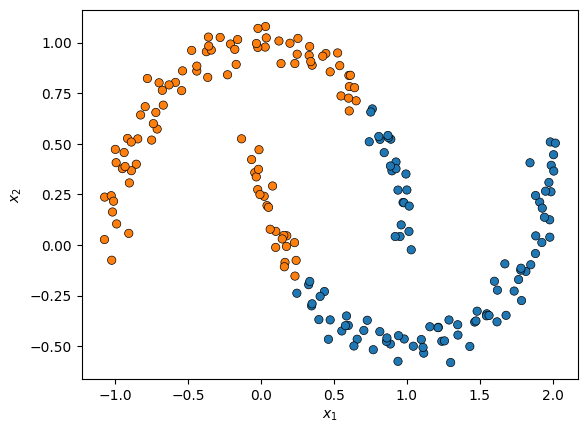

In [20]:
def plot_clusters(X, labels):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='tab10', edgecolor='k', legend=False)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

plot_clusters(X, labels)

It is evident that the two clusters are split into separate sections. This suggests that a neighborhood width of $\sigma = 1$ is too large for this dataset. Let's decrease the width of the neighborhood to $\sigma = 0.15$ (which is about half the distance between the two closest points in the two clusters). To that end, we need to set $γ = 1 / (2 \times 0.15^2) = 22.222$. We will round it down to 20.

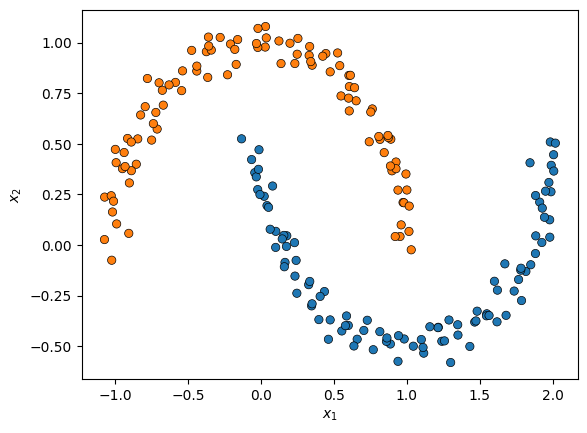

In [21]:
sc = SpectralClustering(n_clusters=2, gamma=20, random_state=0) 
labels = sc.fit_predict(X)

plot_clusters(X, labels)

One of the main advantages of spectral over other clustering algorithms, such as k-means, hierarchical clustering, or DBSCAN, is that it can handle clusters with varying shapes, sizes, and densities.

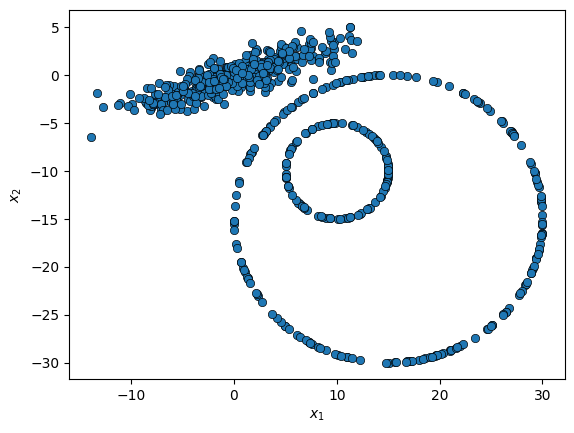

In [22]:
def compound_data(random_seed=0):
    random_state = np.random.RandomState(random_seed)
    
    # Generate the three clusters    
    # 1. Main elliptical cluster
    x1 = random_state.normal(0, 5, 400)
    y1 = x1 / 3 + random_state.normal(0, 1, 400)

    # 2. Small circle cluster
    angle2 = random_state.uniform(0, 2 * np.pi, 100)
    x2 = 5 * np.cos(angle2) + 10
    y2 = 5 * np.sin(angle2) - 10

    # 3. Larger circle cluster
    angle3 = random_state.uniform(0, 2 * np.pi, 200)
    x3 = 15 * np.cos(angle3) + 15
    y3 = 15 * np.sin(angle3) - 15

    return np.vstack((np.hstack((x1, x2, x3)), np.hstack((y1, y2, y3)))).T

X = compound_data()
plot_data(X)

The following figure shows the results of running various clustering algorithms on this dataset:

<div style="align:center">
    <img src="media/comparison.png">
</div>

## Summary

**Pros:**
- Can handle clusters with complex geometries.
- Can identify clusters of varying shapes and sizes.
- Can be used to cluster data that is represented as a graph by partitioning the graph into groups of similar nodes. This is useful for various applications such as detecting communities in social networks or grouping genes with similar expression patterns in bioinformatics.
- Has a strong theoretical foundation.

**Cons:**
- Requires the user to specify the number of clusters in advance.
- The choice of parameters, such as the similarity function and its parameters (e.g., $\sigma$ in the RBF kernel or the number of nearest neighbors) can significantly affect the clustering results.
- Sensitive to outliers, since these can significantly affect the graph’s structure.
- Computing the eigenvalues and eigenvectors of the graph Laplacian can be computationally expensive, especially for large datasets.